In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("/project/scripts/query/"), '../..')))

from pymilvus import (
    connections,
    MilvusClient
)

import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import argparse

from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

from policies.constants import (MILVUS_HOST, MILVUS_PORT, MILVUS_NAMESPACE,
                                LOG_PATH, RESULT_PATH)
from policies.components import get_model, inference

from index_utils import search, search_global

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
class VectorDataset(Dataset):
    def __init__(self, milvus, embedding, global_k, global_accuracy, global_f, local_k, fragment_offset, accuracy, result_path, frame_path, parallelism_candidates, parallelism_exports):
        # Search Global Index for candidates
        candidates, _ = search_global("global", embedding.detach().numpy(), ["collection"], int(global_k), float(global_accuracy), global_f)
        
        # Generate video fragments
        fragments = []
        with ThreadPoolExecutor(max_workers=int(parallelism_candidates)) as executor:
            search_partial = partial(
                search, 
                milvus_client=milvus, 
                embedding=embedding.detach().numpy(), 
                fields=["offset", "pk"], 
                local_k=int(local_k),
                fragment_offset=int(fragment_offset), 
                accuracy=float(accuracy), 
                result_path=result_path,
                parallelism=int(parallelism_exports)
            )
            futures = {executor.submit(search_partial, collection_name=collection_name): collection_name for collection_name in candidates}

            for future in as_completed(futures):
                collection_name = futures[future]
                try:
                    fragment, _, _ = future.result()
                    fragments.extend(fragment)
                except Exception as e:
                    print(f"Error processing collection {collection_name}: {e}")

        # Save individual images on disk
        self.frame_path = frame_path # Path to store the frame .jpgs
        frame_count = 0
        print("Generating dataset...")
        for file in fragments:
            cap = cv2.VideoCapture(f"{result_path}/{file}")
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                cv2.imwrite(f"{frame_path}/frame_{frame_count}.jpg", frame)
                frame_count += 1
            cap.release()
        self.frame_count = frame_count # Dataset length
            
    def __len__(self):
        return self.frame_count

    def __getitem__(self, idx):
        image = Image.open(f"{self.frame_path}/frame_{idx}.jpg")
        image_array = np.array(image)
        return image_array

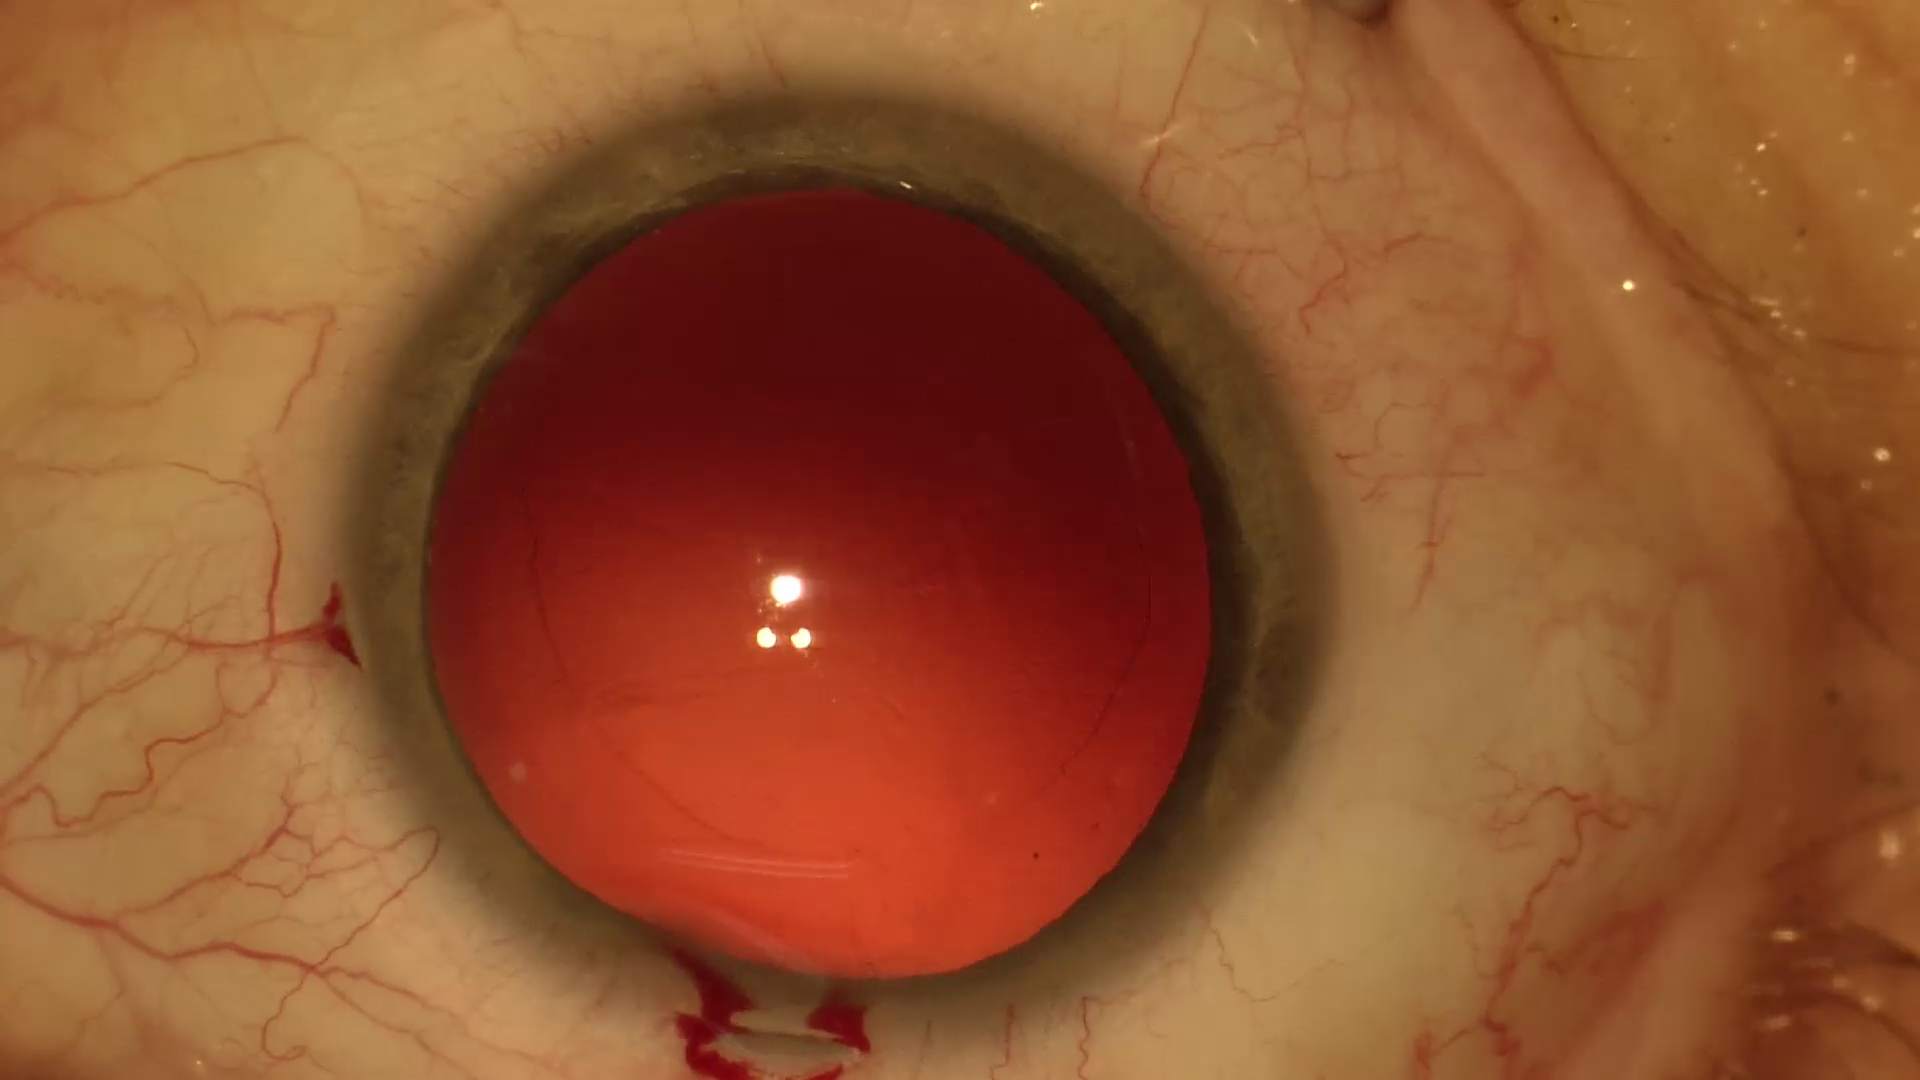

In [3]:
result_path = "/project/results"
os.makedirs(result_path, exist_ok=True)
frame_path = f"{result_path}/frames"
os.makedirs(frame_path, exist_ok=True)

## Read image and perform inference
model, device = get_model()
img = Image.open("/project/benchmarks/experiment3/cat_frame_ref.png")
img.show()
if img.mode == 'RGBA':
    img = img.convert('RGB')
img.resize((940, 560))
embedding = inference(model, img, device)

In [4]:
## Connect to Milvus
print("Connecting to Milvus")
connections.connect("default", host="localhost", port=19530)
client = MilvusClient(uri=f"http://localhost:19530")

## Create the dataset and dataloader
dataset = VectorDataset(
    milvus=client,
    embedding=embedding,
    global_k=3,
    global_accuracy=0.0,
    global_f=20,
    local_k=25,
    fragment_offset=5,
    accuracy=0.85,
    result_path=RESULT_PATH,
    parallelism_candidates=3,
    parallelism_exports=3,
    frame_path=frame_path
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
print("Dataset Generated!")

Connecting to Milvus
Total hits: 60
Searching in cat03
Searching in cat02
Searching in cat01
Exporting fragments from cat03
Exporting fragments from cat01
Exporting fragments from cat02
Generating dataset...
Dataset Generated!


Batch 0 with shape: torch.Size([4, 560, 940, 3])


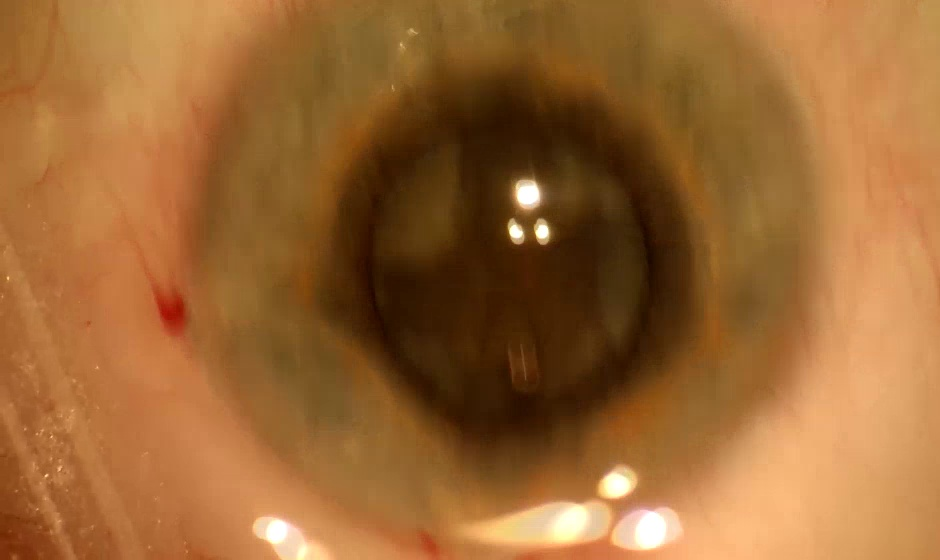

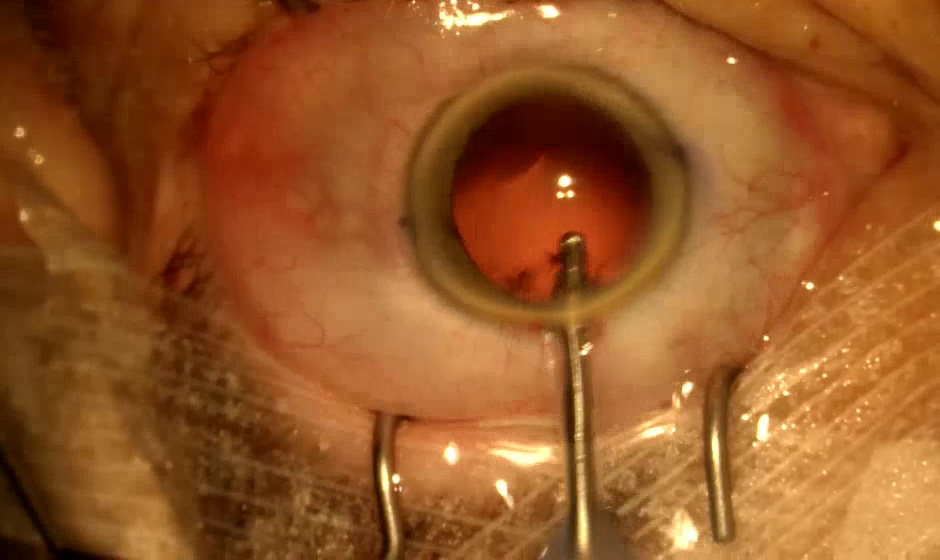

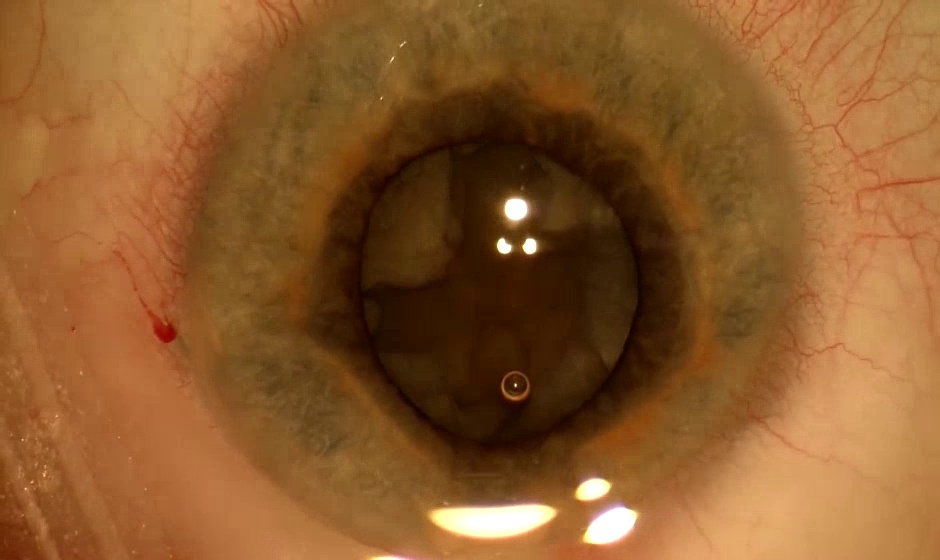

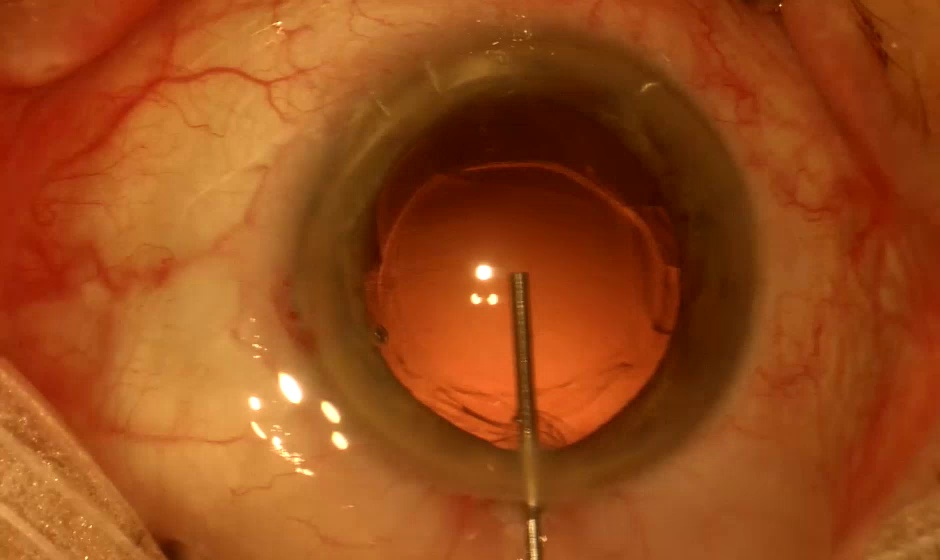

In [5]:
## Example use
for idx, batch in enumerate(dataloader):
    print(f"Batch {idx} with shape: {batch.shape}")
    last = batch
    break
    
# Display last batch in separate window
for idx, img in enumerate(last):
    # Save to disk
    img = Image.fromarray(np.array(img, dtype=np.uint8))
    img.show()